In [3]:
from jax.numpy import zeros, arange, exp, sin, array, pi
from ticktack import load_presaved_model

In [4]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5
PRODUCTION_RATE = 1.76

`jax.lax.scan` will let me make the most of the notes.

In [5]:
from jax.lax import scan 
from functools import partial 

In [30]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None, ):
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [7]:
def production(t, *args, steady_state=PRODUCTION_RATE):
    start, duration, phase, area = array(list(args)).reshape(-1)

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [8]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
carbon_box_model.compile()

In [9]:
time_out = arange(-225, 775)
oversample = 1008
parameters = (774.86, 0.25, 0.8, 6.44)
growth_season = array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [35]:
_, y_initial = carbon_box_model.run(time_out, oversample, \
    production, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

In [11]:
import matplotlib.pyplot as plt

In [39]:
time_out = arange(750, 800)
oversample = 10

In [40]:
odeint_sample_1, _ = carbon_box_model.run(time_out, oversample, \
    production, y0=ode_next_y0, args=parameters, \
    steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

lin_ode_sample_1, _ = carbon_box_model.run(time_out, oversample, \
    production, solver=odeint_linear, y0=lin_next_y0, args=parameters, \
    steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

Text(0.5, 1.0, '10 Samples per year')

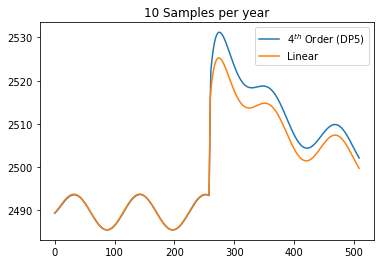

In [49]:
plt.plot(odeint_sample_1[:, 1])
plt.plot(lin_ode_sample_1[:, 1])
plt.legend(["$4^{th}$ Order (DP5)", "Linear"])
plt.title("10 Samples per year")